In [1]:
%pip install osmnx
%pip install contextily
%pip install networkx

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import osmnx as ox
import contextily

import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as la
import numpy as np

In [3]:
north = 49.314886
south = 49.1754210
east = -123.002603
west = -123.267771


bounding_box = (west,south,east,north)

G = ox.graph.graph_from_bbox(bounding_box, network_type = 'drive')

In [4]:
def plot_graph(f,ax,edges):
    edges.plot(linewidth=.25, ax=ax, color='k')
    contextily.add_basemap(ax=ax,
                        crs=edges.crs,
                        source = contextily.providers.CartoDB.Voyager)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

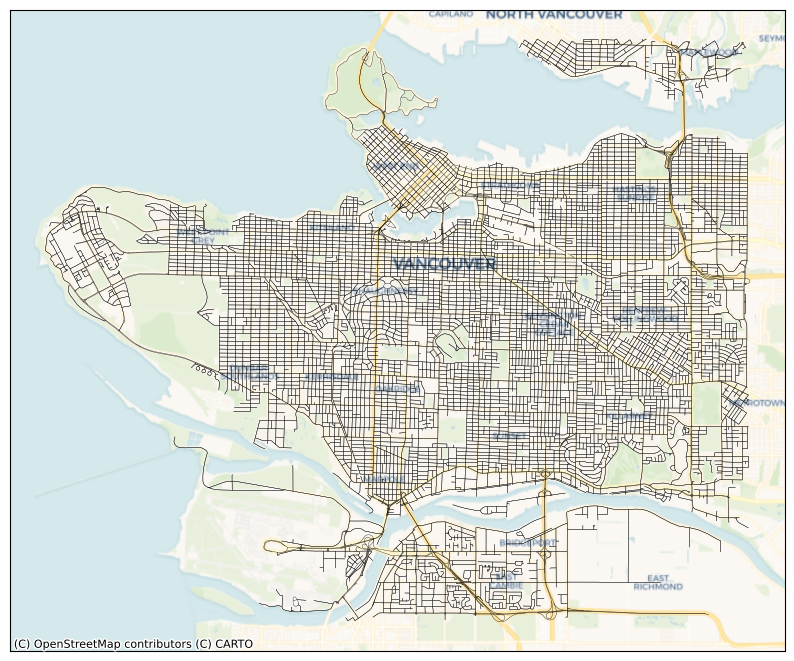

In [5]:
nodes, edges  = ox.graph_to_gdfs(G)

f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph(f,ax,edges)

In [6]:
stores_downtown = [
    (49.291074726223876, -123.1345112715533),
    (49.285778717275015, -123.1388610469531),
    (49.28543824009544, -123.12140394834859),
    (49.288086333967435, -123.11403832867163),
    (49.28108749140217, -123.12134595134327),
    (49.27953626208601, -123.1155462508102),
    (49.28131449647768, -123.10713668503729)
]

stores_van = [
    (49.26710745424008, -123.24276573624313),
    (49.26495239140005, -123.17770621538237),
    (49.269395328423684, -123.15949483697254),
    (49.264310005956226, -123.13849432853601),
    (49.236563149786534, -123.1543967279795)
]

stores_eastvan = [
    (49.265501224782504, -123.1167840944718),  
    (49.264156985091404, -123.06992053669686),  
    (49.260348107095176, -123.04365634497684),  
    (49.26762952939976, -123.02494525414363),  
    (49.24711277560665, -123.10169652190295),  
    (49.24640207307076, -123.06359221703782),  
    (49.23452058476019, -123.06597739540537),  
    (49.207897379250966, -123.12469600383916),  
    (49.21458384969505, -123.10853491891567),  
    (49.22126941578986, -123.07746972234048),
    (49.272454228734645, -123.1004652050492),  
    (49.281730801002375, -123.03062404165448)
]

storage = [(49.19415257260286, -123.17518597496046)]

stores = storage + stores_downtown + stores_van + stores_eastvan
len(stores)

25

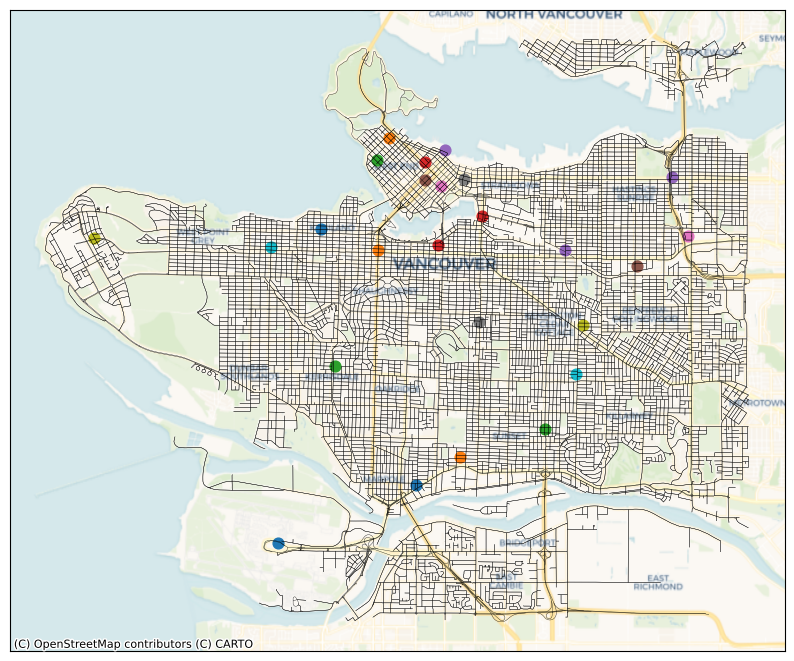

In [7]:
f,ax = plt.subplots(1,1, figsize=(10,12))
plot_graph(f,ax,edges)
for point in stores:
    latitude,longitude = point
    ax.scatter(longitude,latitude,s=60,label = point)
plt.show()

In [8]:
important_nodes = [ox.distance.nearest_nodes(G, point[1],point[0]) 
                   for point in stores]
G = ox.distance.add_edge_lengths(G)

In [9]:
shortest_paths = [[nx.shortest_path(G,node_0,node_1,weight='length') 
                   for node_1 in important_nodes] for node_0 in important_nodes]
shortest_path_lengths = np.array([
    [nx.shortest_path_length(G,node_0,node_1,weight='length') for node_1 in important_nodes]
    for node_0 in important_nodes
])

In [10]:
def get_path_edges(path_nodes,edges):
    edge_list = [(path_nodes[j],path_nodes[j+1]) for j in range(len(path_nodes)-1)]
    return edges[edges.index.isin(edge_list)]

def plot_paths(f,ax,tour,shortest_paths,lwidth):
    for i in range(len(tour)-1):
        shortest_path_edges = get_path_edges(shortest_paths[tour[i]][tour[i+1]],edges)
        shortest_path_edges.plot(linewidth=lwidth, ax=ax, color='b')
    shortest_path_edges = get_path_edges(shortest_paths[tour[-1]][tour[0]],edges)
    shortest_path_edges.plot(linewidth=lwidth, ax=ax, color='b')

def cost_matrix(V):
    n = V.shape[0]
    C = np.zeros((n,n))
    for i in range(1,n):
        for j in range(0,i):
            C[i,j] = np.sqrt((V[j,0] - V[i,0])**2 + (V[j,1] - V[i,1])**2)
            C[j,i] = C[i,j]
    return C

def tour_cost(C,tour):
    n = len(tour)
    cost = 0
    for i in range(n-1):
        cost += C[tour[i],tour[i+1]]
    cost += C[tour[-1],tour[0]]
    return cost

def nearest_neighbor(V,start=0, C = None):
    n = V.shape[0]
    if C is None:
        C = cost_matrix(V)
    tour = [start]
    nodes = list(range(n))
    nodes.remove(start)
    for i in range(1,n):
        next_i = np.argmin(C[tour[-1],nodes])
        next_node = nodes[next_i]
        tour.append(next_node)
        nodes.pop(next_i)
    cost = tour_cost(C,tour)
    return tour,cost

In [11]:
V = np.array(stores)

In [12]:
tour,cost = nearest_neighbor(V,start = 0, C=shortest_path_lengths)
tour_named = [stores[i] for i in tour]
tour_named

[(49.19415257260286, -123.17518597496046),
 (49.207897379250966, -123.12469600383916),
 (49.21458384969505, -123.10853491891567),
 (49.22126941578986, -123.07746972234048),
 (49.23452058476019, -123.06597739540537),
 (49.24640207307076, -123.06359221703782),
 (49.264156985091404, -123.06992053669686),
 (49.260348107095176, -123.04365634497684),
 (49.26762952939976, -123.02494525414363),
 (49.281730801002375, -123.03062404165448),
 (49.28131449647768, -123.10713668503729),
 (49.27953626208601, -123.1155462508102),
 (49.28108749140217, -123.12134595134327),
 (49.28543824009544, -123.12140394834859),
 (49.288086333967435, -123.11403832867163),
 (49.291074726223876, -123.1345112715533),
 (49.285778717275015, -123.1388610469531),
 (49.264310005956226, -123.13849432853601),
 (49.265501224782504, -123.1167840944718),
 (49.272454228734645, -123.1004652050492),
 (49.24711277560665, -123.10169652190295),
 (49.236563149786534, -123.1543967279795),
 (49.26495239140005, -123.17770621538237),
 (49.2

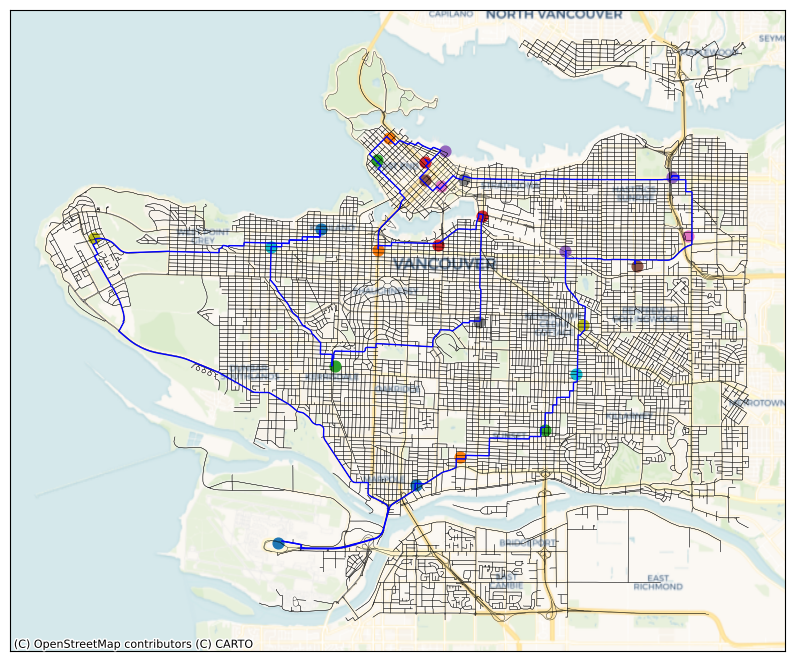

In [13]:
f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph(f,ax,edges)
for point in stores:
    ax.scatter(point[1],point[0],s=60)
plot_paths(f,ax,tour,shortest_paths,1)
plt.show()

## 2 cars to deliver by alternatively choose the next nearest stores. 

Car 1 distance: 61115.906007662314
Car 2 distance: 39498.85833445396


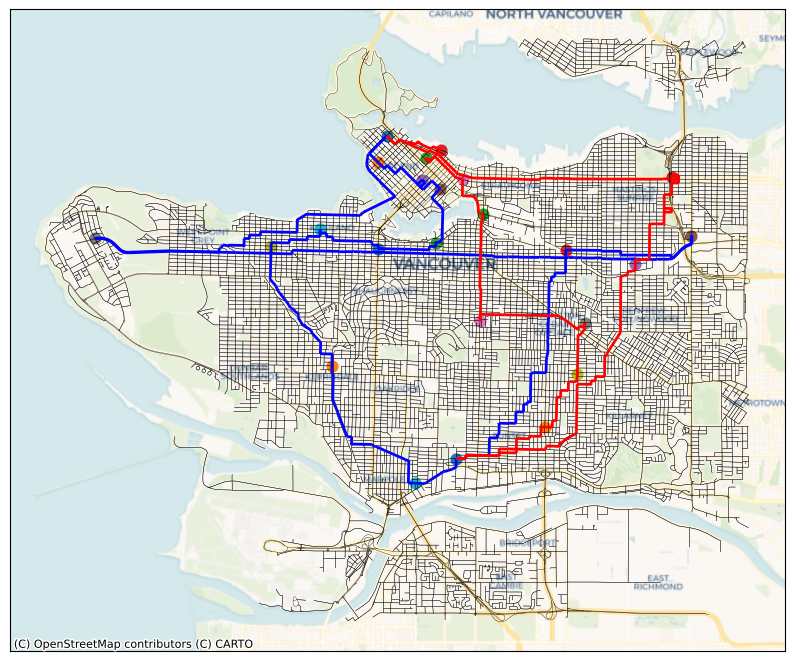

In [25]:

yvr = (49.19415257260286, -123.17518597496046)

all_nodes = [ox.distance.nearest_nodes(G, lon, lat) for lat, lon in stores]


distance_matrix = np.array([
    [nx.shortest_path_length(G, node_from, node_to, weight='length') 
     for node_to in all_nodes] 
    for node_from in all_nodes
])


def greedy_two_car_routing(dist_matrix):
    n_points = dist_matrix.shape[0]
    unvisited = set(range(1, n_points))
    routes = [[0],[0]]
    distances = [0,0]
    car_turn = 0
    while unvisited:
        last_point = routes[car_turn][-1]
        nearest_point = min(unvisited, key=lambda p: dist_matrix[last_point, p])
        routes[car_turn].append(nearest_point)
        distances[car_turn] += dist_matrix[last_point, nearest_point]
        unvisited.remove(nearest_point)
        car_turn = 1 - car_turn
    for car in [0,1]:
        last_point = routes[car][-1]
        distances[car] += dist_matrix[last_point, 0]
        routes[car].append(0)
    return routes, distances

# 可视化
def plot_two_car_routes(G, edges, all_nodes, routes, color_list=['blue', 'red']):
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot_graph(f, ax, edges)
    for node in all_nodes:
        x = G.nodes[node]['x']
        y = G.nodes[node]['y']
        ax.scatter(x, y, s=60)
    for car_idx, route in enumerate(routes):
        for i in range(len(route) - 1):
            path_nodes = nx.shortest_path(G, all_nodes[route[i]], all_nodes[route[i+1]], weight='length')
            path_edges = get_path_edges(path_nodes, edges)
            path_edges.plot(linewidth=2, ax=ax, color=color_list[car_idx])
    plt.show()

# 运行贪心算法并打印两车距离
routes, distances = greedy_two_car_routing(distance_matrix)
print("Car 1 distance:", distances[0])
print("Car 2 distance:", distances[1])

# 画出两车路线
plot_two_car_routes(G, edges, all_nodes, routes)


Car 1 distance: 45555.68307566587
Car 2 distance: 45610.95532495402


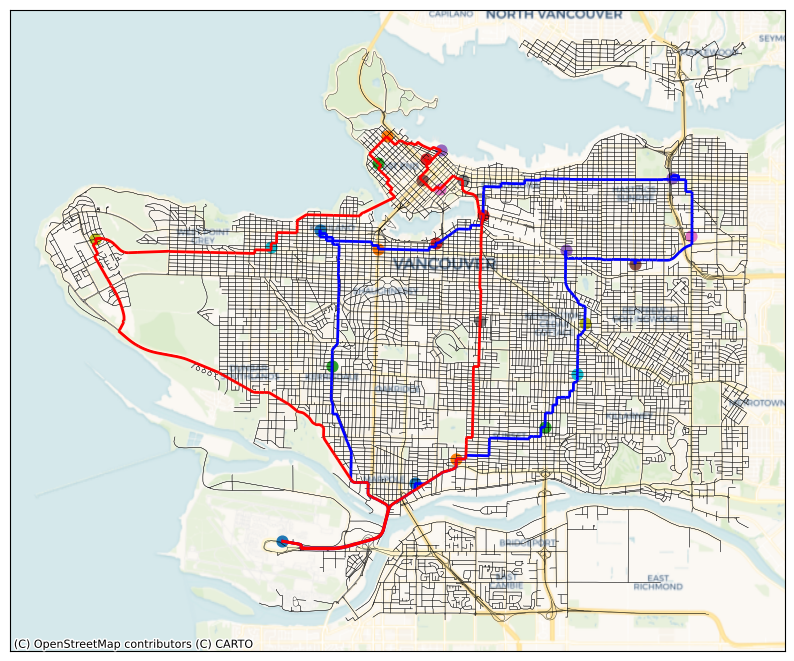

In [27]:
yvr = (49.19415257260286, -123.17518597496046)

all_points = [yvr] + stores
all_nodes = [ox.distance.nearest_nodes(G, lon, lat) for lat, lon in all_points]

distance_matrix = np.array([
    [nx.shortest_path_length(G, node_from, node_to, weight='length') 
     for node_to in all_nodes] 
    for node_from in all_nodes
])


def greedy_two_car_routing(dist_matrix):
    n_points = dist_matrix.shape[0]
    unvisited = set(range(1, n_points))
    routes = [[0], [0]]
    distances = [0, 0]
    car_turn = 0
    while unvisited:
        last_point = routes[car_turn][-1]
        nearest_point = min(unvisited, key=lambda p: dist_matrix[last_point, p])
        routes[car_turn].append(nearest_point)
        distances[car_turn] += dist_matrix[last_point, nearest_point]
        unvisited.remove(nearest_point)
        car_turn = 1 - car_turn
    for car in [0, 1]:
        last_point = routes[car][-1]
        distances[car] += dist_matrix[last_point, 0]
        routes[car].append(0)
    return routes, distances


def plot_two_car_routes(G, edges, all_nodes, routes, color_list=['blue', 'red']):
    f, ax = plt.subplots(1, 1, figsize=(10, 10))
    plot_graph(f, ax, edges)
    for node in all_nodes:
        x = G.nodes[node]['x']
        y = G.nodes[node]['y']
        ax.scatter(x, y, s=60)
    for car_idx, route in enumerate(routes):
        for i in range(len(route) - 1):
            path_nodes = nx.shortest_path(G, all_nodes[route[i]], all_nodes[route[i+1]], weight='length')
            path_edges = get_path_edges(path_nodes, edges)
            path_edges.plot(linewidth=2, ax=ax, color=color_list[car_idx])
    plt.show()

routes, distances = greedy_two_car_routing(distance_matrix)

print("Car 1 distance:", distances[0])
print("Car 2 distance:", distances[1])

plot_two_car_routes(G, edges, all_nodes, routes)


## 2 cars 2 stores

Car1 distance = 38068.94821072665
Car2 distance = 34544.620157549376


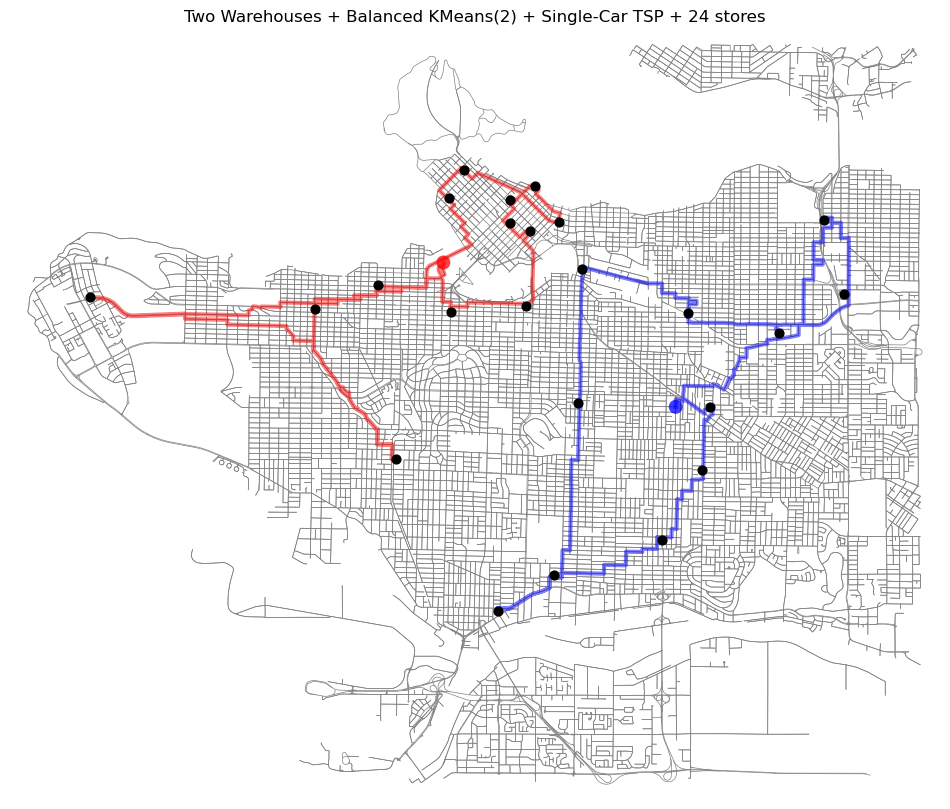

In [22]:
from sklearn.cluster import KMeans

north = 49.314886
south = 49.1754210
east  = -123.002603
west  = -123.267771


stores = stores_downtown + stores_van + stores_eastvan
X = np.array(stores)

def balanced_kmeans_2(X, max_diff=2, random_state=0):
    kmeans = KMeans(n_clusters=2, random_state=random_state).fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    while True:
        c0_idx = np.where(labels==0)[0]
        c1_idx = np.where(labels==1)[0]
        diff = abs(len(c0_idx) - len(c1_idx))
        if diff <= max_diff:
            break
        bigger = 0 if len(c0_idx)>len(c1_idx) else 1
        smaller = 1 - bigger
        bigger_idx = np.where(labels==bigger)[0]
        dist_big   = np.linalg.norm(X[bigger_idx] - centers[bigger], axis=1)
        dist_small = np.linalg.norm(X[bigger_idx] - centers[smaller], axis=1)
        delta_dist = dist_small - dist_big
        order = np.argsort(delta_dist)
        for idx_in_bigger in order:
            real_idx = bigger_idx[idx_in_bigger]
            labels[real_idx] = smaller
            if abs(np.sum(labels==0) - np.sum(labels==1)) <= max_diff:
                break
        for c in [0,1]:
            group = X[labels==c]
            if len(group)>0:
                centers[c] = group.mean(axis=0)
    return labels, centers

labels, centers = balanced_kmeans_2(X, max_diff=2, random_state=42)


def clip_to_bbox(lat, lon, north, south, east, west):
    lat_clip = max(south, min(north, lat))
    lon_clip = max(west,  min(east,  lon))
    return (lat_clip, lon_clip)

wh1 = clip_to_bbox(centers[0,0], centers[0,1], north, south, east, west)
wh2 = clip_to_bbox(centers[1,0], centers[1,1], north, south, east, west)

warehouse_node_1 = ox.distance.nearest_nodes(G, wh1[1], wh1[0]) 
warehouse_node_2 = ox.distance.nearest_nodes(G, wh2[1], wh2[0])

cluster_0_points = X[labels==0]
cluster_1_points = X[labels==1]

cluster_0_nodes = [warehouse_node_1]
cluster_1_nodes = [warehouse_node_2]

for (lat, lon) in cluster_0_points:
    n = ox.distance.nearest_nodes(G, lon, lat)
    cluster_0_nodes.append(n)

for (lat, lon) in cluster_1_points:
    n = ox.distance.nearest_nodes(G, lon, lat)
    cluster_1_nodes.append(n)


def build_dist_matrix(G, nodes):
    n = len(nodes)
    M = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if i!=j:
                M[i,j] = nx.shortest_path_length(G, nodes[i], nodes[j], weight='length')
    return M

dist0 = build_dist_matrix(G, cluster_0_nodes)
dist1 = build_dist_matrix(G, cluster_1_nodes)


def greedy_one_car_routing(dist_mat):
    n_points = dist_mat.shape[0]
    unvisited = set(range(1, n_points))
    route = [0]
    total_dist = 0
    while unvisited:
        last_p = route[-1]
        nearest = min(unvisited, key=lambda p: dist_mat[last_p,p])
        route.append(nearest)
        total_dist += dist_mat[last_p, nearest]
        unvisited.remove(nearest)
    total_dist += dist_mat[route[-1], 0]
    route.append(0)
    return route, total_dist

route_idx_0, cost0 = greedy_one_car_routing(dist0)
route_idx_1, cost1 = greedy_one_car_routing(dist1)
print("Car1 distance =", cost0)
print("Car2 distance =", cost1)


def build_full_path(G, nodes, route_idx):
    fullpath = []
    for i in range(len(route_idx)-1):
        start_i = route_idx[i]
        end_i   = route_idx[i+1]
        seg = nx.shortest_path(G, nodes[start_i], nodes[end_i], weight='length')
        if i==0:
            fullpath.extend(seg)
        else:
         
            fullpath.extend(seg[1:])
    return fullpath

route_nodes_0 = build_full_path(G, cluster_0_nodes, route_idx_0)
route_nodes_1 = build_full_path(G, cluster_1_nodes, route_idx_1)


fig, ax = ox.plot_graph(
    G,
    show=False,
    close=False,
    bgcolor='white',
    node_color='none',
    edge_color='gray',
    edge_linewidth=0.5,
    figsize=(12,12))

ox.plot_graph_route(
    G,
    route_nodes_0,
    route_color='red',
    route_linewidth=3,
    orig_dest_node_size=80,
    ax=ax,
    show=False,
    close=False)

ox.plot_graph_route(
    G,
    route_nodes_1,
    route_color='blue',
    route_linewidth=3,
    orig_dest_node_size=80,
    ax=ax,
    show=False,
    close=False)

for (lat, lon) in stores:
    ax.scatter(lon, lat, c='black', s=40, marker='o', zorder=5)

plt.title("Two Warehouses + Balanced KMeans(2) + Single-Car TSP + 24 stores")
plt.show()